# Create pseudo-lightcurve of SDO/HMI transit of Venus

The SDO/HMI instrument observed the 2012 transit of Venus in great detail, so aside from the interest in the solar physics, it provides us with an interesting real dataset for testing exoplanet transit fitting techniques.

To get started with testing the exoplanet methods, we need to convert the resolved images of the transit into a lightcurve, like that which would be observed for an exoplanet transit. The SDO/HMI continuum images for the time of the 2012 transit of Venus were extracted from the [JSOC archive](http://jsco.stanford.edu/), all 45 s cadence continuum images from 4th June to the end of 7th June 2012 were downloaded.

This notebook goes through the steps taken to create and detrend that lightcurve ready for transit modeling.

First, import all the dependeces needed to extract a pseudo-lightcurve from the images

In [1]:
%pylab inline

import warnings
warnings.filterwarnings("ignore") # to remove some warnings about bad fits headers

import glob
import numpy as np
import matplotlib.pylab as plt
import seaborn as sb
import pandas as pd

from astropy.utils.console import ProgressBar
from astropy.stats import LombScargle
from astropy.io import fits
from astropy.time import Time

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF, WhiteKernel

Populating the interactive namespace from numpy and matplotlib


### Make the lightcurve

Find all the HMI intensity files, and then loop through each of the images, and extract useful observational metadata, as well as sum all pixels that have positive values for each image. This has generated our initial lightcurve.

In [ ]:
# (this will only work if you also download the several GB of SDO images...)
listed = glob.glob('../sdo_raw_data/solar_venus_data/*.fits')
print('number of files:',len(listed))

In [ ]:
intensities = []
times = []
rsun_obs = []
with ProgressBar(len(listed),ipython_widget=True) as bar:
    for file in listed:
        with fits.open(file) as f:
            f.verify('fix')
            times.append(f[1]._header['DATE-OBS'])
            rsun_obs.append(f[1].header['RSUN_OBS'])
            _data = np.array(f[1].data)
            _data = np.nan_to_num(_data)
            _data[_data<0] = 0
            intensities.append(np.nansum(_data))
            

        bar.update()

In [ ]:
# Convert time to JD for convenience
t = Time(times, format='isot', scale='utc')
times = t.jd

### Correct for apparent size of sun

Since the SDO spacecraft is in orbit around the earth, the apparent size of the sun on the CCD varies from image to image. This means that the values for the summed intensities are dependent on the number of illuminated pixels in that image. 

For an exoplanet transit, the host star would not be varying in apparent size in this way, so that effect should be corrected for. Since the apparent size at each time is known, this can be done relatatively simply. The intensity values for each image are therefore scaled with the square of the apparent solar radius for each image, and then median normalised.

In [ ]:
ys2 = np.array(intensities)/np.square(np.array(rsun_obs))
ys2 = ys2/np.median(ys2)

### Existing data

Since looping through each of the ~7000 images takes a bit of time, here's a quick alternative start point to avoid repeating that step unecessarily.

In [2]:
_data = pd.read_csv('./venus_data.csv')
times = np.array(_data['times'])
ys2 = np.array(_data['raw_flux'])

### Plot the initial lightcurve

Having constructed the lightcurve, we can take a look at what the initial extracted lightcurve actually looks like. The expected transit can clearly be seen around JD=2456084.5, however there is a large and significant pseudo-periodic signal also very apparent in the plot. 

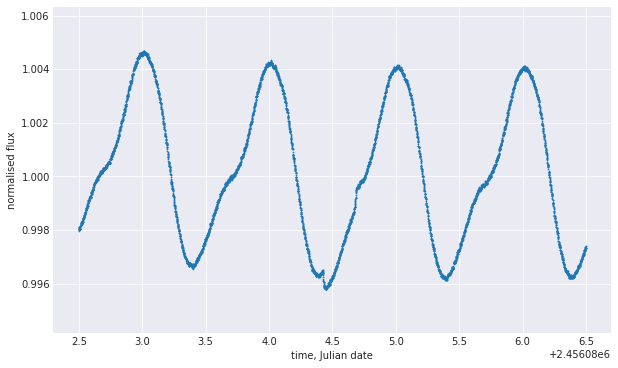

In [3]:
with sb.axes_style('darkgrid'):
    fig, axs = plt.subplots(1,1, figsize=(10,6))
    axs.scatter(times, ys2,s=0.5)
    plt.setp(axs,xlabel='time, Julian date',ylabel='normalised flux')
    #fig.savefig('venus_nonorm.png')

### Side note on periodicity

Even with this initial lightcurve, if we run a Lomb-Scargle periodogram on the data, just looking at the short period variation, we can very clearly see a strong peak at a period of 0.035 days = 5 mins, which is the expected timescale of solar granulation variability. 

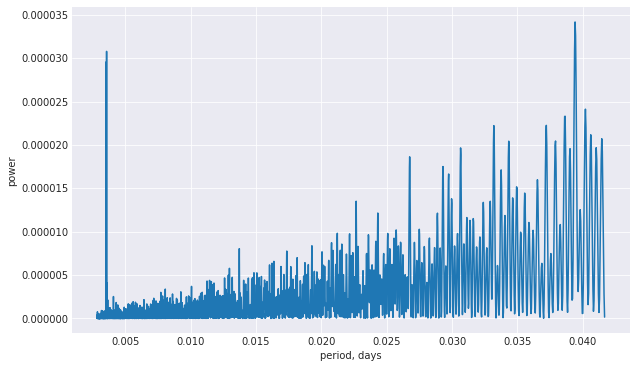

In [4]:
frequency, power = LombScargle(times,ys2).autopower(minimum_frequency=24.,
                                                    maximum_frequency=350,
                                                    samples_per_peak=10)

with sb.axes_style('darkgrid'):
    fig, axs = plt.subplots(1,1, figsize=(10,6))
    axs.plot(1/frequency, power)
    plt.setp(axs,xlabel='period, days',ylabel='power')
    #plt.setp(axs,xlim=[0.003,0.005])

### Correcting for instrumental signal

Obviously there isn't such a large real variation in the solar flux in this wavelength, so the signal is being introduced by the spacecraft itself, or the way that the continuum intensity image is being constructed. This hypothesis is supported by other work with SDO/HMI data: 

> Since the orbit [of SDO] is accurately known, it would seem that removal of the artefacts should be straightforward, but even five years into the mission, the exact mechanisms that contaminate the data remain a mystery and the rigorous removal of the artefacts has not been acomplished

>[Shuck, P.W., et al. ApJ, 823:101 2016](http://iopscience.iop.org/article/10.3847/0004-637X/823/2/101/meta)

Since there is no defined method to account for the variations, and that they are seemingly smooth, **Gaussian Processes** are well suited to model the signal. The signal at a first glance seems periodic, but is actually evolving with each cycle, so a quasi-periodic kernal is the optimal choice for modeling the covariance function.

The quasi-periodic kernel has the form:
$$ k(t) = \sigma^{2} \exp \left( - \frac{2\sin^{2}\left(\pi \, t \,/\, P \right)}{l_{1}^{2}} \right) \exp \left( - \frac{t^{2}}{l_{2}^{2}} \right) $$
where $\sigma$ is the amplitude of the signal; $t$ is the input time signal; $P$ is the periodicity hyperparameter; $l_{1}$ is the length scale, which refers to how much harmonic content the periodicity contains, and $l_{2}$ is the length scale for how stable the periodicity is over multiple periods. For a smooth (and nearer sinusoidal) period, $l_{1}$ should be large, and for increasing harmonic content, a smaller value for $l_{1}$ would be found.

#### Preparing the data

Add some low-level white noise to the signal, and add an error bar. This will prevent the GP from over-fitting the stellar noise, and then just fit the overall long term systematic signal that we want to correct for. 

Since fitting a GP scales with $O(N^{3})$, it is often useful to fit with a down-sampled dataset. Setting the parameter `fac` will down-sample the data by that factor.

In [5]:
noise = np.random.normal(0,0.00005,ys2.shape)

_ys2 = ys2 + noise
yerr = np.ones_like(ys2)*0.0001

X = np.atleast_2d(np.hstack((times[times<2456084.42],times[times>2456084.69]))).T
#X = np.atleast_Normalised flux2d(times).T
Y = np.hstack((_ys2[times<2456084.42],_ys2[times>2456084.69]))
#Y = np.atleast_2d(ys2).T
YERR = np.hstack((yerr[times<2456084.42],yerr[times>2456084.69]))
#YERR = np.atleast_2d(yerr).T

fac = 1
X = X[::fac,:]
Y = Y[::fac]
YERR = YERR[::fac]

#### Preparing the kernel and fitting the GP

The periodicity comes from the spacecraft orbit, so the GP period hyper-parameter is set as the orbital period of the spacecraft. 

In [6]:
period = 1436.14/(60.*24.) # orbital period of SDO in days

a = 0.01
b = RBF(length_scale=5.0)
c = ExpSineSquared(length_scale=0.5, periodicity=period, periodicity_bounds=(period-0.001,period+0.001))
kernel = a * b * c

gp = GaussianProcessRegressor(kernel=kernel,alpha=YERR**2.,normalize_y=True)
gp.fit(X,Y)

print("Learned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f" % gp.log_marginal_likelihood(gp.kernel_.theta))

Learned kernel: 0.00316**2 * RBF(length_scale=3.19) * ExpSineSquared(length_scale=1.06, periodicity=0.998)
Log-marginal-likelihood: 57636.977


#### Plotting the results

The GP has been trained on the raw lightcurve, so now we can predict the form of the systematic signal, and leave the residuals of the fit as our test-bed lightcurve.

In [7]:
X_ = np.atleast_2d(np.linspace(X.min() - 0.5, X.max() + 0.5, 1000)).T
y_pred, y_std = gp.predict(X_, return_std=True)

y_pred2, y_std2 = gp.predict(np.atleast_2d(times).T, return_std=True)

In [8]:
cp = sb.color_palette('deep')
# set colours
i = 0
ij = 1
ii = 2
jj = 3

_X_ = X_ - 2450000.
_X = X - 2450000.
_times = times - 2450000.

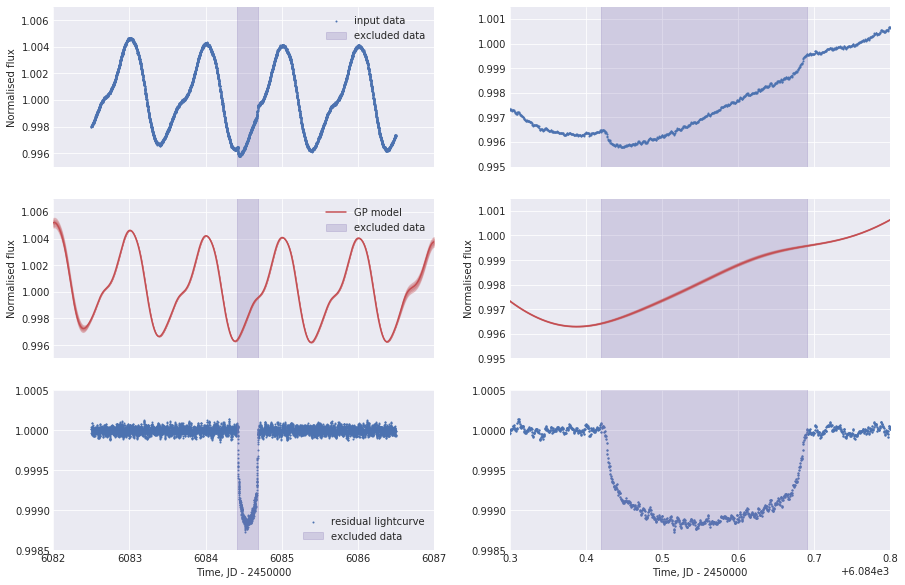

In [16]:
with sb.axes_style('darkgrid'):
    fig,axs = plt.subplots(3,2,figsize=(15,10),sharex='col')
    ax = axs.flatten()
    
    ax[0].scatter(_times,ys2,s=1,c=cp[i],zorder=3,label='input data')
    ax[0].fill_between([6084.42,6084.69],[0.9,0.9],[1.1,1.1],alpha=0.25,color=cp[jj],label='excluded data')
    ax[0].legend(loc=1)
    plt.setp(ax[0],xlim=[6082.,6087.],ylim=[0.995,1.007])
    plt.setp(ax[0],ylabel='Normalised flux')
    
    ax[1].scatter(_times,ys2,s=1,c=cp[i],zorder=3,label='input data')
    ax[1].fill_between([6084.42,6084.69],[0.9,0.9],[1.1,1.1],alpha=0.25,color=cp[jj],label='excluded data')
    plt.setp(ax[1],xlim=[6084.3,6084.8],ylim=[0.995,1.0015])
    
    ax[2].plot(_X_,y_pred,c=cp[ii],zorder=4,label='GP model')
    ax[2].fill_between(_X_[:,0], (y_pred - y_std), (y_pred + y_std),alpha=0.25, color=cp[ii],zorder=4)
    ax[2].fill_between(_X_[:,0], (y_pred - y_std*2.), (y_pred + y_std*2.),alpha=0.25, color=cp[ii],zorder=4)
    ax[2].fill_between(_X_[:,0], (y_pred - y_std*3.), (y_pred + y_std*3.),alpha=0.25, color=cp[ii],zorder=4)
    ax[2].fill_between([6084.42,6084.69],[0.9,0.9],[1.1,1.1],alpha=0.25,color=cp[jj],label='excluded data')
    ax[2].legend(loc=1)
    plt.setp(ax[2],xlim=[6082.,6087.],ylim=[0.995,1.007])
    plt.setp(ax[2],ylabel='Normalised flux')
    
    ax[3].plot(_X_,y_pred,c=cp[ii],zorder=4)
    ax[3].fill_between(_X_[:,0], (y_pred - y_std), (y_pred + y_std),alpha=0.25, color=cp[ii],zorder=4)
    ax[3].fill_between(_X_[:,0], (y_pred - y_std*2.), (y_pred + y_std*2.),alpha=0.25, color=cp[ii],zorder=4)
    ax[3].fill_between(_X_[:,0], (y_pred - y_std*3.), (y_pred + y_std*3.),alpha=0.25, color=cp[ii],zorder=4)
    ax[3].fill_between([6084.42,6084.69],[0.9,0.9],[1.1,1.1],alpha=0.25,color=cp[jj],label='excluded data')   
    plt.setp(ax[3],xlim=[6084.3,6084.8],ylim=[0.995,1.0015])
    plt.setp(ax[3],ylabel='Normalised flux')

    ax[4].scatter(_times,ys2/y_pred2,s=1,c=cp[i],label='residual lightcurve')
    ax[4].fill_between([6084.42,6084.69],[0.9,0.9],[1.1,1.1],alpha=0.25,color=cp[jj],label='excluded data')
    plt.setp(ax[4],xlim=[6082.,6087.],ylim=[0.9985,1.0005])
    plt.setp(ax[4],xlabel='Time, JD - 2450000')
    ax[4].legend(loc=4)
    
    ax[5].scatter(_times,ys2/y_pred2,s=2,c=cp[i])
    ax[5].fill_between([6084.42,6084.69],[0.9,0.9],[1.1,1.1],alpha=0.25,color=cp[jj],label='excluded data')
    plt.setp(ax[5],ylim=[0.9985,1.0005],xlim=[6084.3,6084.8])
    plt.setp(ax[5],xlabel='Time, JD - 2450000')

And we can save that lightcurve to use in an MCMC fit of the transit parameters

In [ ]:
dat = pd.DataFrame(np.vstack((times,(ys2/y_pred2))).T,
               
    fig.savefig('gp_detrend.pdf')        columns=['times','flux'])
dat.to_csv('venus_data_scikit.csv',index=False)

### Orbital geometry

Since the transit of Venus is observed from SDO (in orbit around earth), the geometry of the transit is not the same as that for an exoplanet transit, so we need to correct for that to ensure we get physically sensible transit parameters when using our exoplanet transit model.

The transit of Venus will also appear larger than it would for the same size exoplanet, but it is simpler to retain the observed trasnit depth, and assume that we are looking at a larger exoplanet.

The geometric correction applied comes from the observed transit duration, which is shorter than would be expected for the same sized star with an exoplanet transit.

This is the expected transit duration for an exoplanet, orbiting a star with solar density, and an observed transit depth, $\Delta F$:

$$T = \frac{P}{\pi} \left( \frac{3\pi}{G P^{2} \rho_{\odot}} \right)^{\frac{1}{3}}\left( 1 - b^{2} \right) $$

The expected duration of the transit of Venus is:

$$T' = 2 \frac{R_{\odot} \left( \frac{1}{a_V} - \frac{1}{a_E} \right)}{\omega_V - \omega_E} \left( 1 - b^2 \right)$$

The factor to divide the observation times by is:

$$ Fac = \frac{T'}{T} $$

In [ ]:
dip = 0.001025 # transit depth (from initial lightcurve fit)
per = 224.7 # orbital period of Venus
d_s = 60. * 60. * 24. # seconds in 1 day
per = per*d_s # convert to seconds
G = 6.67408E-11 # gravitational constant
b = 0.613 # impact parameter (from images of transit)
R_sun = 695700.*(10**3) # solar radius in m
R_venus = 6051.8*(10**3) # venus radius in m
AU = 1.49E11 # 1 AU in m
a_v = 0.728213*AU # orbital separation of Venus and Sun
a_e = AU # orbital separation of Earth and Sun
omega_v = 2.*np.pi/per # orbital frequency of Venus
omega_e = 2.*np.pi/(365.*d_s) # orbital frequency of Earth
rho_sun = 1410. # solar density in kg/m^3

obs_dur = 2.*(1.-b**2.)*(R_sun*((1/a_v)-(1/a_e)))/(omega_v - omega_e)

exp_dur = (per/np.pi)*((3.*np.pi/(G*per*per*rho_sun))**(1./3.))*(1-(b**2.))

print('obs_dur (days):',obs_dur/d_s)
print('exp_dur (days):',exp_dur/d_s)

In [ ]:
with sb.axes_style():
    fig,axs = plt.subplots(1,1,figsize=(10,6))
    axs.scatter(times/(obs_dur/exp_dur),ys2/y_pred2,s=1)
    plt.setp(axs,ylim=[0.998,1.001])

In [ ]:
dat = pd.DataFrame(np.vstack((times/(obs_dur/exp_dur),(ys2/y_pred2))).T,
                   columns=['times','flux'])
dat.to_csv('venus_data_scikit_timefactor.csv',index=False)